# **Tutorial 9: Paleoclimate Reanalysis Products**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Yosmely Bermúdez, Dionessa Biton, Katrina Dobson, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Zahra Khodakaramimaghsoud, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

As we discussed in the video, proxies and models both have advantages and limitations for reconstructing past changes in Earth's climate system. One approach for combining the strengths of both paleoclimate proxies and models is data assimilation. This is the same approach used in Day 2, except instead of simulations of Earth's recent past, we are using a simulation that spans many thousands of years back in time and is constrained by proxies, rather than modern instrumental measurements. The results of this process are called reanalysis products.

In this tutorial, we'll look at paleoclimate reconstructions from the Last Glacial Maximum Reanalysis (LGMR) product from [Osman et al. (2021)](https://www.nature.com/articles/s41586-021-03984-4), which contains temperature for the past 24,000 years.


During this tutorial you will:

*   Plot a time series of the paleoclimate reconstruction
*   Create global maps and zonal mean plots of temperature anomalies 
*   Assess how and why LGM to present temperature anomalies vary with latitude






# Setup

In [1]:
# !pip install --no-binary shapely shapely --force #this allows us to load cartopy
# !pip install cartopy
# !pip install pooch
# !pip install xarray

In [2]:
# imports
import pooch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.util as cutil

In [3]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# **Section 1: Load the LGMR Paleoclimate Reconstruction**

This dataset contains a reconstruction of surface air temperature (SAT) from the product [Last Glacial Maximum Reanalysis (LGMR)](https://www.ncdc.noaa.gov/paleo/study/33112). Note that this data starts from 100 years before present and goes back in time to ~24,000 BP. The period of time from ~21,000 to 18,000 years ago is referred to as the Last Glacial Maximum (LGM). The LGM was the most recent glacial period in Earth's history. During this time, northern hemisphere ice sheets were larger, global sea level was lower, atmospheric CO<sub>2</sub> was lower, and global mean temperature was cooler. (Note: if you are interested in looking at data for the present to last millenium, that reanalyses product is available [here](https://www.ncei.noaa.gov/access/paleo-search/study/27850).)

We will calculate the global mean temperature from the LGM to 100 years before present  from a paleoclimate data assimilation to asses how Earth's climate varied over the past 24,000 years.

First let's download the paleoclimate data assimilation reconstruction for surface air temperature (SAT). 

In [4]:
url_LGMR_SAT_climo="https://www.ncei.noaa.gov/pub/data/paleo/reconstructions/osman2021/LGMR_SAT_climo.nc"
ds = xr.open_dataset(pooch.retrieve(url_LGMR_SAT_climo,known_hash=None))
ds

/Users/jennapearson/anaconda3/envs/climatematch/lib/python3.10/site-packages/xarray/coding/variables.py:214: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

## **Section 1.1: Plotting the Temperature Time Series**

Now that the data is loaded, we can plot a time series of the temperature data to assess global changes. However, the dimensions of the `sat_mean` variable are age-lat-lon, so we first need to weight the data and calculate a global mean.

In [5]:
# assign weights
weights = np.cos(np.deg2rad(ds.lat))

# calculate the global mean surface temperature
sat_global_mean = ds.sat.weighted(weights).mean(dim=['lat', 'lon'])
sat_global_mean

<xarray.DataArray 'sat' (age: 120)>
array([13.488816 , 13.379799 , 13.367699 , 13.41764  , 13.521231 ,
       13.483701 , 13.448242 , 13.453558 , 13.393461 , 13.364498 ,
       13.356941 , 13.345207 , 13.372342 , 13.322996 , 13.280973 ,
       13.266106 , 13.206199 , 13.231979 , 13.198052 , 13.191569 ,
       13.202925 , 13.226294 , 13.262333 , 13.289269 , 13.300678 ,
       13.327042 , 13.265094 , 13.226639 , 13.239835 , 13.259315 ,
       13.2716255, 13.284225 , 13.281981 , 13.243568 , 13.154917 ,
       13.134473 , 13.051164 , 13.044024 , 13.018783 , 13.056285 ,
       13.054654 , 13.010315 , 13.015508 , 12.881076 , 12.863064 ,
       12.861096 , 12.687558 , 12.569263 , 12.524812 , 12.439435 ,
       12.289819 , 12.246099 , 12.267493 , 12.194947 , 12.081889 ,
       11.919093 , 11.661677 , 11.351944 , 11.001435 , 10.625317 ,
       10.470679 , 10.239214 , 10.043142 ,  9.934955 ,  9.998024 ,
       10.120449 , 10.112263 ,  9.9829445,  9.841059 ,  9.742364 ,
        9.561579 ,  9.335905 ,  9.121109 ,  8.890101 ,  8.663934 ,
        8.3901615,  8.11417  ,  7.8677363,  7.680047 ,  7.3794174,
        7.1652136,  7.0298505,  6.8594747,  6.5461307,  6.3129888,
        6.1813235,  6.1011453,  6.1283407,  6.0942235,  6.074231 ,
        6.177226 ,  6.260221 ,  6.2024117,  6.247197 ,  6.3203106,
        6.390161 ,  6.4032025,  6.360986 ,  6.3122416,  6.3190217,
        6.3962164,  6.3993335,  6.4049506,  6.3988714,  6.3890047,
        6.397364 ,  6.50859  ,  6.571201 ,  6.6173353,  6.6346164,
        6.6801257,  6.7983932,  6.894402 ,  7.01163  ,  7.06175  ,
        7.095675 ,  7.171442 ,  7.1770988,  7.2501955,  7.356061 ],
      dtype=float32)
Coordinates:
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04

Now that we calculated our global mean, we can plot the results as a time series to assess global changes in temperature over the past 24,000 years:

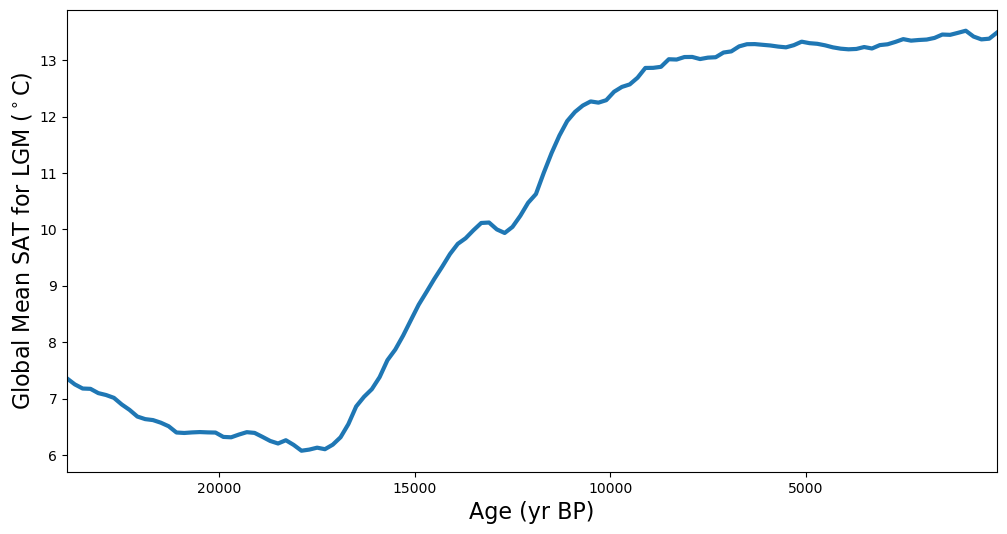

In [6]:
# plot the global mean surface temperature since the LGM
f,ax1 = plt.subplots(1, 1, figsize=(12,6))
ax1.plot(ds['age'], sat_global_mean, linewidth=3)

ax1.set_xlim(ds['age'].max().values, ds['age'].min().values)
ax1.set_ylabel('Global Mean SAT for LGM ($^\circ$C)', fontsize=16)
ax1.set_xlabel('Age (yr BP)', fontsize=16)
plt.show()

### **Questions 1.1: Climate Connection**
1.   How has global temperature varied over the past 24,000 years?
2.   What climate forcings may have contributed to the increase in temperature ~17,000 years ago? 

In [7]:
# to_remove explanation

"""
1.In the span of the last 24,000 years, there has been a considerable shift in global temperatures, transitioning from the colder phase of the Last Glacial Maximum to the relatively warmer Holocene epoch we are currently experiencing. This transformation was not linear, with periods of rapid warming interspersed with intervals of relative stability or even temporary cooling. 
2.The increase in temperature around 17,000 years ago was likely driven by a combination of climate forcings: obliquity and eccentricity, both affect the amount of solar radiation reaching the Earth's surface.

""";

## **Section 1.2: Plotting a Temperature Anomaly Map**

The reanalysis contains *spatial* reconstructions, so we can also make figures showing spatial temperature anomalies for different time periods (i.e., the change in temperature between two specified times). The anomaly that we'll interpret is the difference between global temperature from 18,000 to 21,000 years ago (i.e. "LGM") and 100 to 1,000 years ago (i.e. "modern") . First, we'll calculate the average temperatures for each time period.

In [8]:
# calculate the LGM (18,000-21,000 year) mean temperature
lgm = ds.sat.sel(
    age=slice('18000', '21000'),lon=slice(0, 357.5), lat=slice(-90, 90)
)
lgm_mean = lgm.mean(dim='age')

# calculate the "modern" (100-1000 year) mean temperature
modern = ds.sat.sel(
    age=slice('100', '1000'),lon=slice(0, 357.5), lat=slice(-90, 90)
)
modern_mean = modern.mean(dim='age')

Now we can calculate the anomaly and create a map to visualize the change in temperature from the LGM to present in different parts on Earth.

In [9]:
sat_change = modern_mean - lgm_mean

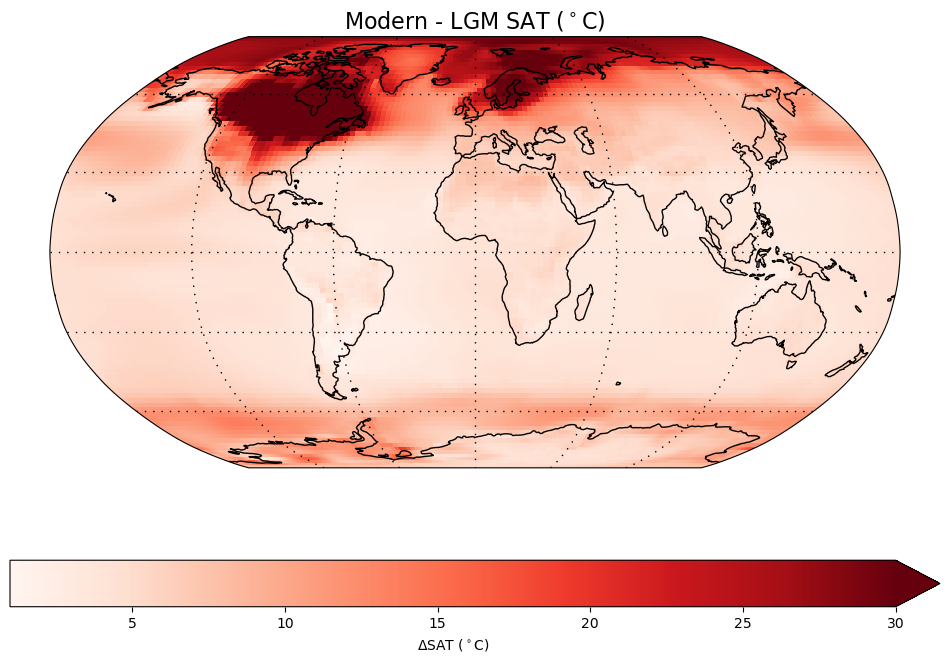

In [10]:
# make a map of changes
plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
sat_change.plot(
    ax=ax,
    transform=ccrs.PlateCarree(), x="lon", y="lat", cmap = 'Reds', vmax = 30,
    cbar_kwargs={'orientation': 'horizontal', 'label':'$\Delta$SAT ($^\circ$C)'}
)
ax.coastlines()
ax.set_title(
    f'Modern - LGM SAT ($^\circ$C)',
    loc='center',
    fontsize=16
)
ax.gridlines(color='k',linewidth=1,linestyle=(0,(1,5)))
ax.spines['geo'].set_edgecolor('black')
plt.show()

Before we interpret this data, another useful way to visualize this data is through a plot of zonal mean temperature (the average temperature for all locations at a single latitude). Once we calculate this zonal mean, we can create a plot of LGM to present temperature anomalies versus latitude.

In [11]:
zonal_mean = sat_change.mean(dim='lon')
latitude = ds.lat

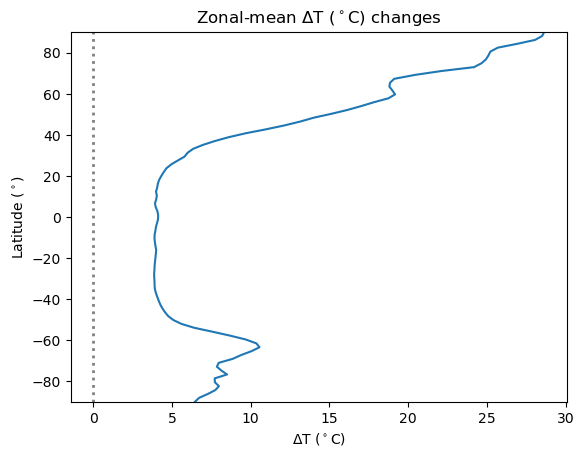

In [12]:
# Make a zonal mean figure of the changes
fig, ax1 = plt.subplots(1, 1)
plt.plot(zonal_mean,latitude)
ax1.axvline(x=0,color='gray',alpha=1,linestyle=':',linewidth=2)
ax1.set_ylim(-90, 90)
ax1.set_xlabel('$\Delta$T ($^\circ$C)')
ax1.set_ylabel('Latitude ($^\circ$)')
ax1.set_title(
    f'Zonal-mean $\Delta$T ($^\circ$C) changes', # ohad comment: same changes
    loc='center',
    )
plt.show()

### **Questions 1.1: Climate Connection**

Looking at both the map and zonal mean plot, consider the following questions: 

1. How does the temperature anomaly vary with latitude? 
2. What might be causing spatial differences in the temperature anomaly?

In [13]:
# to_remove explanation 

"""
1. Although there was a global increase in temperature between the LGM to present, the magnitude of this warming (i.e., the temperature anomaly) varied with latitude. Generally, the high latitudes, particularly in the north experienced larger warming than the tropics. 

2. This pattern is known as polar amplification, which is caused by a number of factors including changes in albedo as ice sheets melt, changes in atmospheric and oceanic circulation, and changes in the distribution of solar insolation.

""";

# **Summary**
In this last tutorial of this day, you explored the intersection of paleoclimate proxies and models through reanalysis products, specifically analyzing the Last Glacial Maximum Reanalysis (LGMR) from Osman et al. (2021).

Through this tutorial, you've learned a range of new skills and knowledge:
- Interpreting Paleoclimate Reconstructions: You have learned how to decode and visualize the time series of a paleoclimate reconstruction of surface air temprature from a reanalysis product in order to enhance your understanding of the temperature variations from the Last Glacial Maximum to the present day.
- Constructing Global Temperature Anomaly Maps: You've acquired the ability to construct and understand global maps that represent temperature anomalies, providing a more holistic view of the Earth's climate during the Last Glacial Maximum.
- Examining Latitude's Role in Temperature Variations: You've explored how temperature anomalies from the Last Glacial Maximum to the present day vary by latitude and pondered the reasons behind these variations, enriching your understanding of latitudinal effects on global climate patterns.

# **Resources**

The code for this notebook is based on [code available from Erb et al. (2022)](https://github.com/Holocene-Reconstruction/Holocene-code) and workflow presented during the [Paleoclimate Data Assimilation Workshop 2022](https://github.com/michaelerb/da-workshop).

Data from the following sources are used in this tutorial:

*   Matthew B. Osman, Jessica E. Tierney, Jiang Zhu, Robert Tardif, Gregory J. Hakim, Jonathan King, Christopher J. Poulsen. 2021. Globally resolved surface temperatures since the Last Glacial Maximum. Nature, 599, 239-244. http://doi.org/10.1038/s41586-021-03984-4.
*   King, J. M., Tierney, J., Osman, M., Judd, E. J., & Anchukaitis, K. J. (2023). DASH: A MATLAB Toolbox for Paleoclimate Data Assimilation. Geoscientific Model Development, preprint. https://doi.org/10.5194/egusphere-2023-68.